In [1]:
import numpy as np
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Question 7 and 8

## Loading data

In [2]:
# load all the mnist data with the data loader and put in the following tensors: (x_train_data, y_train_data), (x_test_data, y_test_data)

def load_mnist_data():

    transform = transforms.Compose([transforms.ToTensor()])

    train_data = datasets.MNIST(root='data', train=True, download=True, transform=transform)
    test_data = datasets.MNIST(root='data', train=False, download=True, transform=transform)

    train_loader = DataLoader(train_data, batch_size=len(train_data))
    test_loader = DataLoader(test_data, batch_size=len(test_data))

    x_train_data, y_train_data = next(iter(train_loader))
    x_test_data, y_test_data = next(iter(test_loader))

    return (x_train_data, y_train_data), (x_test_data, y_test_data)



In [3]:
(x_train_full, y_train_full), (x_test, y_test) = load_mnist_data()

In [4]:
#Split the training data into 50 000 training instances and 10 000 validation instances

def split_data(x_train_data, y_train_data):

    x_train_data, x_val_data = x_train_data[:50000], x_train_data[50000:]
    y_train_data, y_val_data = y_train_data[:50000], y_train_data[50000:]

    return (x_train_data, y_train_data), (x_val_data, y_val_data)

In [5]:
(x_train, y_train), (x_val, y_val) = split_data(x_train_full, y_train_full)

## Implementing the network and training

### Utils

In [6]:

def calculate_loss_and_accuracy(model, x_data, y_data, criterion, batch):
    model.eval()
    loss = 0
    correct = 0
    with torch.no_grad():
        for i in range(0, len(x_data), batch):
            to = min(i + batch, len(x_data))
            x_batch = x_data[i:to]
            y_batch = y_data[i:to]
            output = model(x_batch)
            loss += criterion(output, y_batch).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(y_batch.view_as(pred)).sum().item()
    return loss / len(x_data), correct / len(x_data)

### Defining model and training procedure

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm

# Define the neural network
class MNISTConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)  # 1 input channel, 16 output channels
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)  # 16 input channels, 32 output channels
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)  # 32 input channels, 64 output channels
        self.fc1 = nn.Linear(64 * 3 * 3, 10)  # Flattened to a fully connected layer with 10 outputs

    def forward(self, x):
        x = F.relu(self.conv1(x))  # First convolution + ReLU
        x = F.max_pool2d(x, 2)     # Max pooling 2x2
        x = F.relu(self.conv2(x))  # Second convolution + ReLU
        x = F.max_pool2d(x, 2)     # Max pooling 2x2
        x = F.relu(self.conv3(x))  # Third convolution + ReLU
        x = F.max_pool2d(x, 2)     # Max pooling 2x2
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = self.fc1(x)            # Fully connected layer
        return x

In [8]:

# Training loop that computes the running loss per epoch and validation loss and accuracy per epoch
def train(model, x_train, y_train, x_val, y_val, optimizer, criterion, epochs=10, batch_size=64):

    first_epoch_running_loss = []

    train_evaluations = np.zeros((epochs, 2))
    val_evaluations = np.zeros((epochs, 2))



    for epoch in range(epochs):
        model.train()
        for i in tqdm(range(0, len(x_train), batch_size), desc=f'Batches for epoch {epoch + 1}/{epochs}'):

            to = min(i + batch_size, len(x_train))
            x_batch = x_train[i:to]
            y_batch = y_train[i:to]

            optimizer.zero_grad()
            output = model(x_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()

            if epoch == 0:
                # get average loss and append to list
                first_epoch_running_loss.append(loss.item())

        
        train_loss, train_acc = calculate_loss_and_accuracy(model, x_train, y_train, criterion, batch_size)
        val_loss, val_acc = calculate_loss_and_accuracy(model, x_val, y_val, criterion, batch_size)

        train_evaluations[epoch] = [train_loss, train_acc]
        val_evaluations[epoch] = [val_loss, val_acc]

        print(f'Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

    return first_epoch_running_loss, train_evaluations, val_evaluations








### Training

In [9]:
# Train the model

model = MNISTConvNet()
# Training on CPU (use "cuda" for GPU training if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
# put the data on the device
x_train, y_train, x_val, y_val = x_train.to(device), y_train.to(device), x_val.to(device), y_val.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

first_epoch_running_loss, train_evaluations, val_evaluations = train(model, x_train, y_train, x_val, y_val, optimizer, criterion, epochs=3, batch_size=64)


Batches for epoch 1/3: 100%|██████████| 782/782 [00:16<00:00, 46.48it/s]


Epoch 1/3, Train Loss: 0.0012, Train Acc: 0.9768, Val Loss: 0.0011, Val Acc: 0.9809


Batches for epoch 2/3: 100%|██████████| 782/782 [00:16<00:00, 48.49it/s]


Epoch 2/3, Train Loss: 0.0008, Train Acc: 0.9834, Val Loss: 0.0009, Val Acc: 0.9834


Batches for epoch 3/3: 100%|██████████| 782/782 [00:16<00:00, 46.06it/s]


Epoch 3/3, Train Loss: 0.0007, Train Acc: 0.9866, Val Loss: 0.0008, Val Acc: 0.9858


## Plotting evaluation measures

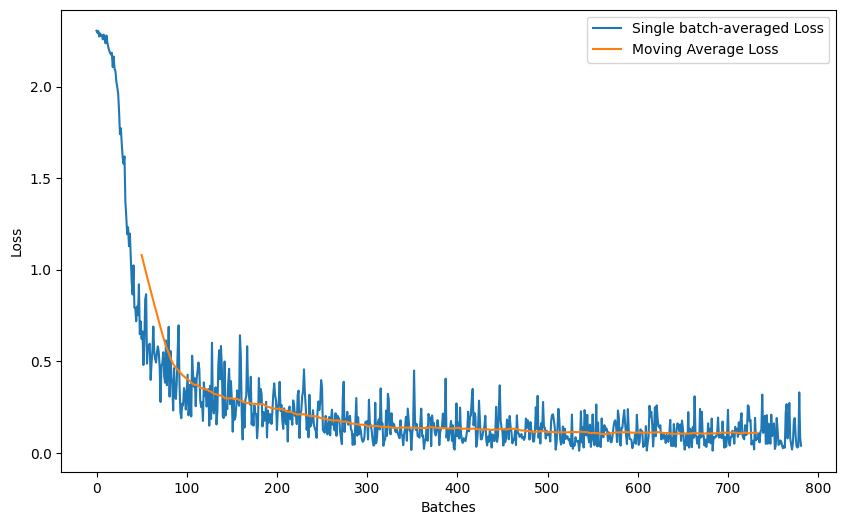

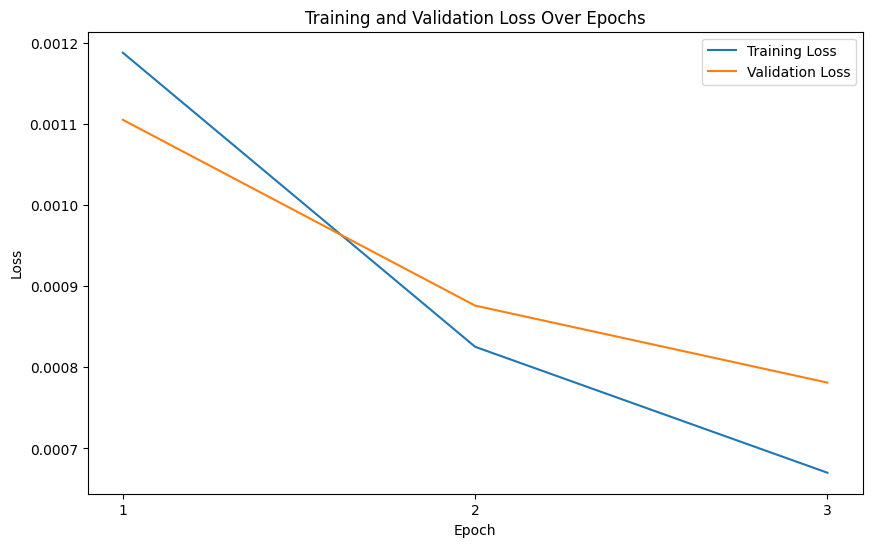

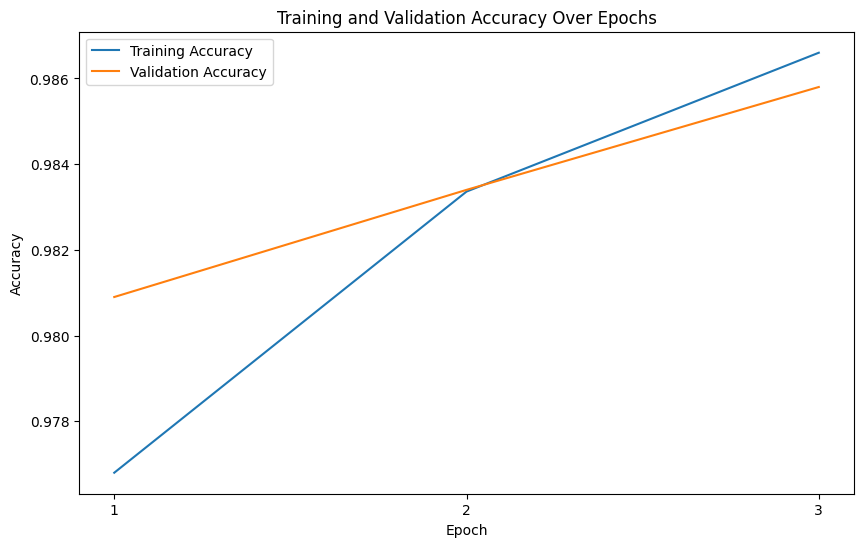

In [16]:
import matplotlib.pyplot as plt

# Plot first epoch running loss

plt.figure(figsize=(10, 6))
plt.plot(first_epoch_running_loss, label="Single batch-averaged Loss")
conv_size = 100
ma_loss = np.convolve(first_epoch_running_loss, np.ones(conv_size), 'valid') / conv_size
plt.plot(np.arange(len(ma_loss))+conv_size/2, ma_loss, label="Moving Average Loss")
plt.xlabel("Batches")
plt.ylabel("Loss")
plt.legend()
plt.show()


# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(train_evaluations[:, 0], label='Training Loss')
plt.plot(val_evaluations[:, 0], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
# adjust x labels to start from 1 and be integers

plt.xticks(np.arange(0, len(train_evaluations) , 1), np.arange(1, len(train_evaluations) + 1, 1))


plt.legend()
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(train_evaluations[:, 1], label='Training Accuracy')
plt.plot(val_evaluations[:, 1], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Over Epochs')
plt.xticks(np.arange(0, len(train_evaluations) , 1), np.arange(1, len(train_evaluations) + 1, 1))
plt.legend()
plt.show()


# Question 11

## Max and Mean pooling

In [ ]:
import torch    

b, c, h, w = 4, 10, 32, 32
x1 = torch.randn(b, c, h, w)
x2 = torch.randn(b, c, h*2, w*2)

x1_mean_pool = x1.mean(dim=(-2, -1))
x1_max_pool = x1.amax(dim=(-2, -1))
# Alteratively
# import torch.nn.functional as F
x1_max_pool_func = F.max_pool2d(x1, kernel_size=x1.size()[2:]).squeeze() # squeeze  because otherwise the shape would be (b, c, 1, 1)
print("x1_max_pool_func shape:", x1_max_pool_func.shape)  # should be (b, c)

x2_mean_pool = x2.mean(dim=(-2, -1))
x2_max_pool = x2.amax(dim=(-2, -1))

print("x1_mean_pool shape:", x1_mean_pool.shape)  # should be (b, c)
print("x1_max_pool shape:", x1_max_pool.shape)    # should be (b, c)

print("x2_mean_pool shape:", x2_mean_pool.shape)  # should be (b, c)
print("x2_max_pool shape:", x2_max_pool.shape)    # should be (b, c)

x1_max_pool_func shape: torch.Size([4, 10, 1, 1])
x1_mean_pool shape: torch.Size([4, 10])
x1_max_pool shape: torch.Size([4, 10])
x2_mean_pool shape: torch.Size([4, 10])
x2_max_pool shape: torch.Size([4, 10])


## Data Loading

For the code below to work you should add the decompressed minist_varres folder inside ./data/MNIST

In [ ]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import Compose, Resize, ToTensor

# Load the variable resolution dataset
varres_transform = Compose([  
    ToTensor()
])

varres_test = ImageFolder(root='./data/MNIST/mnist-varres/test', transform=varres_transform)

vatters_train = ImageFolder(root='./data/MNIST/mnist-varres/train', transform=varres_transform)

# Split into training and validation sets
train_size = int(0.8 * len(vatters_train))
val_size = len(vatters_train) - train_size
train_varres_dataset, val_varres_dataset = torch.utils.data.random_split(vatters_train, [train_size, val_size])


# Create data loaders
train_varres_loader = DataLoader(train_varres_dataset, batch_size=64, shuffle=True)
val_varres_loader = DataLoader(val_varres_dataset, batch_size=64, shuffle=False)

test_varres_loader = DataLoader(varres_test, batch_size=64, shuffle=False)

